In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Creating a dataset

In [2]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
TEST_SIZE = 0.2
LEARNING_RATE = 0.1
EPOCHS = 200

In [3]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
X_blob, Y_blob = make_blobs(n_samples=1000, 
                            n_features=NUM_FEATURES, 
                            centers=NUM_CLASSES, 
                            random_state=RANDOM_SEED,
                            cluster_std=1,
                            )

X_blob = torch.from_numpy(X_blob).type(torch.float)
Y_blob = torch.from_numpy(Y_blob).type(torch.float)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_blob, Y_blob, test_size=TEST_SIZE, random_state=RANDOM_SEED)

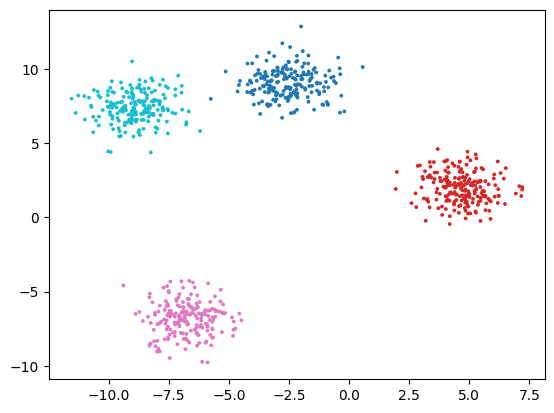

In [5]:
# Plot the training data
plt.scatter(X_train[:, 0], X_train[:, 1], s=3, c=Y_train, cmap=plt.cm.tab10)

In [6]:
# Create a model
class MultiClassClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(num_features, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.linear(x)

In [7]:
# Define accuracy percentage function
def accuracy(y_pred, y_true):
    return 100*(torch.argmax(y_pred, dim=1) == y_true).float().mean()

In [8]:
# Create the model
model_0 = MultiClassClassifier(NUM_FEATURES, NUM_CLASSES).to(device)
LOSS_FUNC = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=LEARNING_RATE)

In [9]:
# # Initialize the model weights
# def init_weights(m):
#     if type(m) == nn.Linear:
#         torch.nn.init.xavier_uniform_(m.weight)
#         m.bias.data.fill_(0.01)

# model_0.apply(init_weights)

In [10]:
X_train.shape, Y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [11]:
# Move the data to the device
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

In [12]:
train_loss_values = []
test_loss_values = []

In [13]:
# Train the model
for epoch in range(EPOCHS):
    model_0.train()
    Y_pred = model_0(X_train)
    loss = LOSS_FUNC(Y_pred, Y_train.type(torch.long))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Append the loss values
    train_loss_values.append(loss.item())
    
    # Print the loss values and accuracy
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Train Loss: {loss.item():.4f} | Train Accuracy: {accuracy(Y_pred, Y_train):.4f}%", end=" | ")
    model_0.eval()
    with torch.no_grad():
        Y_test_pred = model_0(X_test)
        loss = LOSS_FUNC(Y_test_pred, Y_test.type(torch.long))
        if epoch % 10 == 0:
            print(f"Test Loss: {loss.item():.4f}, Test Accuracy: {accuracy(Y_test_pred, Y_test):.4f}%")
        test_loss_values.append(loss.item()) # Append the loss values

Epoch: 0, Train Loss: 1.4361 | Train Accuracy: 12.2500% | Test Loss: 1.2489, Test Accuracy: 47.0000%
Epoch: 10, Train Loss: 0.7497 | Train Accuracy: 99.7500% | Test Loss: 0.7448, Test Accuracy: 100.0000%
Epoch: 20, Train Loss: 0.7449 | Train Accuracy: 99.8750% | Test Loss: 0.7437, Test Accuracy: 100.0000%
Epoch: 30, Train Loss: 0.7449 | Train Accuracy: 99.8750% | Test Loss: 0.7437, Test Accuracy: 100.0000%
Epoch: 40, Train Loss: 0.7449 | Train Accuracy: 99.8750% | Test Loss: 0.7437, Test Accuracy: 100.0000%
Epoch: 50, Train Loss: 0.7449 | Train Accuracy: 99.8750% | Test Loss: 0.7437, Test Accuracy: 100.0000%
Epoch: 60, Train Loss: 0.7442 | Train Accuracy: 100.0000% | Test Loss: 0.7437, Test Accuracy: 100.0000%
Epoch: 70, Train Loss: 0.7442 | Train Accuracy: 99.8750% | Test Loss: 0.7437, Test Accuracy: 100.0000%
Epoch: 80, Train Loss: 0.7449 | Train Accuracy: 99.8750% | Test Loss: 0.7437, Test Accuracy: 100.0000%
Epoch: 90, Train Loss: 0.7449 | Train Accuracy: 99.8750% | Test Loss: 0.74

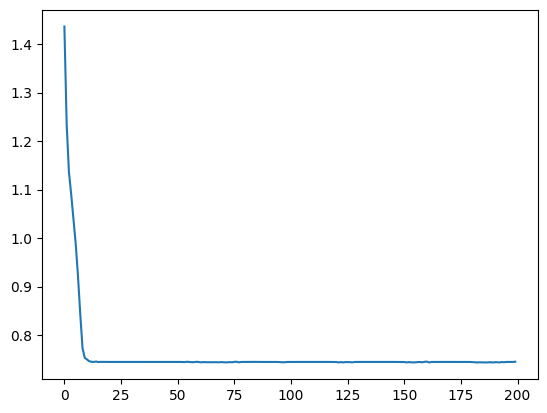

In [14]:
# Plot the loss values
plt.plot(train_loss_values, label="Train Loss")

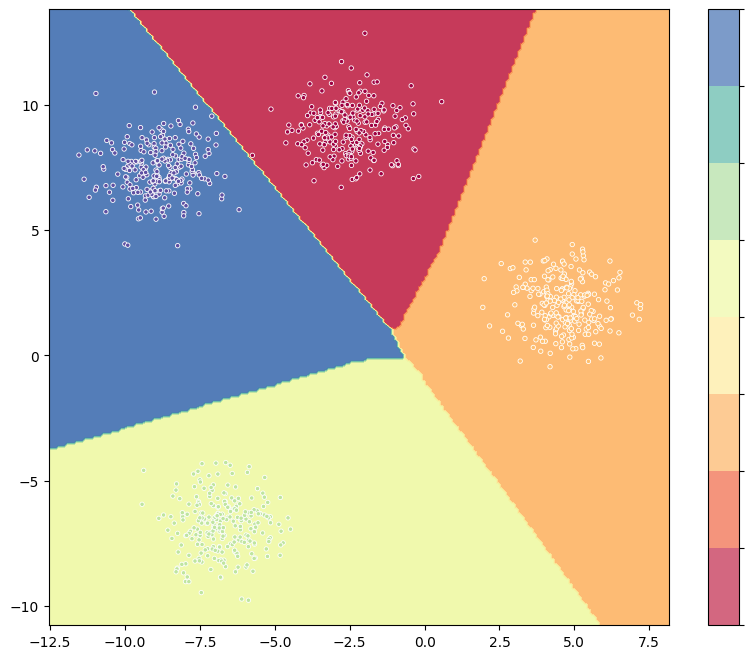

In [557]:
# Make a grid of points
x_min, x_max = X_blob[:, 0].min() - 1, X_blob[:, 0].max() + 1
y_min, y_max = X_blob[:, 1].min() - 1, X_blob[:, 1].max() + 1
xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.1), torch.arange(y_min, y_max, 0.1))
grid_points = torch.stack([xx.flatten(), yy.flatten()], axis=1)

# Make predictions on the grid
model_0.eval()
with torch.no_grad():
    Z = model_0(grid_points.to(device))
    Z = Z.argmax(dim=1).reshape(xx.shape)
# Figure
plt.figure(figsize=(10, 8))
plt.colorbar(mappable=plt.contourf(xx, yy, Z.cpu(), cmap=plt.cm.Spectral, alpha=0.7), format='')
# Plot the decision boundary
plt.contourf(xx, yy, Z.cpu(), cmap=plt.cm.Spectral, alpha=0.7)
plt.scatter(X_blob[:, 0], X_blob[:, 1], s=10, edgecolors='w', linewidths=0.6 ,c=Y_blob, cmap=plt.cm.Spectral)

In [16]:
# Save the model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model_blobs.pt"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)